<a href="https://colab.research.google.com/github/raniaabidi/HTGNNs/blob/main/HTGNN_movies.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
os.environ['LC_ALL'] = 'en_US.UTF-8'

In [ ]:
import pandas as pd
import numpy as np
import networkx as nx
from sklearn.model_selection import train_test_split

# Load the dataset
ratings = pd.read_csv('/content/drive/MyDrive/movielens/ratings_small.csv')

# Convert timestamp to datetime
ratings['timestamp'] = pd.to_datetime(ratings['timestamp'], unit='s')

# Sort by timestamp
ratings = ratings.sort_values(by='timestamp')

# Split the data into train and test sets
train_data, test_data = train_test_split(ratings, test_size=0.2, shuffle=False)

# Create graph structures with numeric timestamps
def create_graph(data):
    G = nx.DiGraph()
    for _, row in data.iterrows():
        G.add_edge(row['userId'], row['movieId'], timestamp=row['timestamp'].timestamp())
    return G

train_graph = create_graph(train_data)
test_graph = create_graph(test_data)

In [ ]:
!pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.2/64.2 kB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 17.8 MB/s eta 0:00:00


In [ ]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data, DataLoader

# Convert NetworkX graph to PyTorch Geometric Data object
def convert_to_pyg_data(graph, num_features=8):
    nodes = list(graph.nodes())
    node_mapping = {node: i for i, node in enumerate(nodes)}
    edge_index = torch.tensor([[node_mapping[u], node_mapping[v]] for u, v in graph.edges]).t().contiguous()
    edge_time = torch.tensor([graph[u][v]['timestamp'] for u, v in graph.edges], dtype=torch.float)

    # Create a feature matrix with fixed number of features per node
    x = torch.randn(len(nodes), num_features)

    # Random labels for the nodes (binary classification: 0 or 1)
    y = torch.randint(0, 2, (len(nodes),))

    data = Data(x=x, edge_index=edge_index, edge_time=edge_time, y=y)
    return data

train_data_pyg = convert_to_pyg_data(train_graph)
test_data_pyg = convert_to_pyg_data(test_graph)

train_loader = DataLoader([train_data_pyg], batch_size=1, shuffle=True)
test_loader = DataLoader([test_data_pyg], batch_size=1, shuffle=False)

class HTGNN(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(HTGNN, self).__init__()
        self.conv1 = GCNConv(in_channels, 8)
        self.conv2 = GCNConv(8 + 8, out_channels)
        self.time_embedding = torch.nn.Embedding(365, 8)

    def forward(self, x, edge_index, edge_time):
        print(f'Input x shape: {x.shape}')
        print(f'Edge index shape: {edge_index.shape}')
        print(f'Edge time shape: {edge_time.shape}')

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        print(f'x after conv1 shape: {x.shape}')

        # Embedding for the edge times
        time_embeds = self.time_embedding((edge_time.long() % 365).view(-1, 1)).view(-1, 8)
        print(f'time_embeds shape: {time_embeds.shape}')

        # Average the edge time embeddings per node
        node_time_embeds = torch.zeros_like(x)
        for i in range(edge_index.size(1)):
            node_time_embeds[edge_index[0, i]] += time_embeds[i]
        print(f'node_time_embeds shape: {node_time_embeds.shape}')

        x = torch.cat([x, node_time_embeds], dim=1)
        print(f'x after concatenation shape: {x.shape}')

        x = self.conv2(x, edge_index)
        print(f'x after conv2 shape: {x.shape}')

        return x

# Initialize the model, loss function, and optimizer
model = HTGNN(in_channels=train_data_pyg.num_node_features, out_channels=2)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
loss_fn = torch.nn.CrossEntropyLoss()


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [ ]:
# Training function
def train(model, loader, optimizer, loss_fn):
    model.train()
    total_loss = 0
    for data in loader:
        optimizer.zero_grad()
        out = model(data.x, data.edge_index, data.edge_time)
        loss = loss_fn(out, data.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

# Evaluation function
def evaluate(model, loader):
    model.eval()
    correct = 0
    for data in loader:
        out = model(data.x, data.edge_index, data.edge_time)
        pred = out.argmax(dim=1)
        correct += (pred == data.y).sum().item()
    return correct / len(loader.dataset)

# Training loop
for epoch in range(100):
    train_loss = train(model, train_loader, optimizer, loss_fn)
    test_acc = evaluate(model, test_loader)
    print(f'Epoch {epoch}, Loss: {train_loss}, Test Accuracy: {test_acc}')

In [ ]:
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

# Function to calculate MRR
def mrr_score(y_true, y_pred):
    order = np.argsort(y_pred)[::-1]
    ranks = np.where(y_true[order] == 1)[0] + 1
    return np.mean(1.0 / ranks)

# Evaluation function with metrics
def evaluate_with_metrics(model, loader):
    model.eval()
    all_preds = []
    all_labels = []
    for data in loader:
        out = model(data.x, data.edge_index, data.edge_time)
        pred = out.argmax(dim=1)
        all_preds.append(pred.detach().cpu().numpy())
        all_labels.append(data.y.detach().cpu().numpy())

    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)

    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='macro')
    recall = recall_score(all_labels, all_preds, average='macro')
    f1 = f1_score(all_labels, all_preds, average='macro')
    mrr = mrr_score(all_labels, all_preds)

    return accuracy, precision, recall, f1, mrr

# Training loop
for epoch in range(100):
    train(model, train_loader, optimizer, loss_fn)
    accuracy, precision, recall, f1, mrr = evaluate_with_metrics(model, test_loader)
    print(f'Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}, F1-Score: {f1}, MRR: {mrr}')

Input x shape: torch.Size([7428, 8])
Edge index shape: torch.Size([2, 80003])
Edge time shape: torch.Size([80003])
x after conv1 shape: torch.Size([7428, 8])
time_embeds shape: torch.Size([80003, 8])
node_time_embeds shape: torch.Size([7428, 8])
x after concatenation shape: torch.Size([7428, 16])
x after conv2 shape: torch.Size([7428, 2])
Input x shape: torch.Size([4850, 8])
Edge index shape: torch.Size([2, 20001])
Edge time shape: torch.Size([20001])
x after conv1 shape: torch.Size([4850, 8])
time_embeds shape: torch.Size([20001, 8])
node_time_embeds shape: torch.Size([4850, 8])
x after concatenation shape: torch.Size([4850, 16])
x after conv2 shape: torch.Size([4850, 2])
Accuracy: 0.5218556701030928, Precision: 0.522043284267993, Recall: 0.5219498906229594, F1-Score: 0.5213917420814624, MRR: 0.0021902938714821727
Input x shape: torch.Size([7428, 8])
Edge index shape: torch.Size([2, 80003])
Edge time shape: torch.Size([80003])
x after conv1 shape: torch.Size([7428, 8])
time_embeds sha

In [ ]:
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.preprocessing import label_binarize

# Function to calculate MRR
def mrr_score(y_true, y_pred):
    order = np.argsort(y_pred)[::-1]
    ranks = np.where(y_true[order] == 1)[0] + 1
    return np.mean(1.0 / ranks)

# Function to calculate NDCG
def ndcg_score(y_true, y_pred, k=10):
    order = np.argsort(y_pred)[::-1]
    y_true = np.take(y_true, order[:k])

    gains = 2 ** y_true - 1
    discounts = np.log2(np.arange(2, k + 2))
    dcg = np.sum(gains / discounts)

    ideal_gains = 2 ** np.sort(y_true)[::-1] - 1
    idcg = np.sum(ideal_gains / discounts)

    return dcg / idcg if idcg > 0 else 0.0

# Evaluation function with metrics
def evaluate_with_metrics(model, loader):
    model.eval()
    all_preds = []
    all_labels = []
    for data in loader:
        out = model(data.x, data.edge_index, data.edge_time)
        pred = out.argmax(dim=1)
        all_preds.append(pred.detach().cpu().numpy())
        all_labels.append(data.y.detach().cpu().numpy())

    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)

    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='macro')
    recall = recall_score(all_labels, all_preds, average='macro')
    f1 = f1_score(all_labels, all_preds, average='macro')
    mrr = mrr_score(all_labels, all_preds)
    ndcg = ndcg_score(all_labels, all_preds)

    return accuracy, precision, recall, f1, mrr, ndcg

# Function to calculate just the accuracy
def calculate_accuracy(model, loader):
    model.eval()
    correct = 0
    total = 0
    for data in loader:
        out = model(data.x, data.edge_index, data.edge_time)
        pred = out.argmax(dim=1)
        correct += (pred == data.y).sum().item()
        total += data.y.size(0)
    accuracy = correct / total
    return accuracy

accuracy, precision, recall, f1, mrr, ndcg = evaluate_with_metrics(model, test_loader)
print(f' NDCG: {ndcg}, Precision: {precision}, Recall: {recall}, F1-Score: {f1}')

accuracy = calculate_accuracy(model, test_loader)
print(f'Final Accuracy: {accuracy}')

Input x shape: torch.Size([4850, 8])
Edge index shape: torch.Size([2, 20001])
Edge time shape: torch.Size([20001])
x after conv1 shape: torch.Size([4850, 8])
time_embeds shape: torch.Size([20001, 8])
node_time_embeds shape: torch.Size([4850, 8])
x after concatenation shape: torch.Size([4850, 16])
x after conv2 shape: torch.Size([4850, 2])
 NDCG: 0.7009124514018641, Precision: 0.4935158023081752, Recall: 0.49415404075403624, F1-Score: 0.4808047086232656
Input x shape: torch.Size([4850, 8])
Edge index shape: torch.Size([2, 20001])
Edge time shape: torch.Size([20001])
x after conv1 shape: torch.Size([4850, 8])
time_embeds shape: torch.Size([20001, 8])
node_time_embeds shape: torch.Size([4850, 8])
x after concatenation shape: torch.Size([4850, 16])
x after conv2 shape: torch.Size([4850, 2])
Final Accuracy: 0.4929896907216495


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os
os.environ['LC_ALL'] = 'en_US.UTF-8'

import pandas as pd
import numpy as np
import networkx as nx
from sklearn.model_selection import train_test_split

# Load the dataset
ratings = pd.read_csv('/content/drive/MyDrive/movielens/ratings_small.csv')

# Convert timestamp to datetime and extract the year
ratings['timestamp'] = pd.to_datetime(ratings['timestamp'], unit='s')
ratings['year'] = ratings['timestamp'].dt.year

# Sort by year
ratings = ratings.sort_values(by='year')

# Split the data into train and test sets
train_data, test_data = train_test_split(ratings, test_size=0.2, shuffle=False)

# Create graph structures with year instead of full timestamp
def create_graph(data):
    G = nx.DiGraph()
    for _, row in data.iterrows():
        G.add_edge(row['userId'], row['movieId'], year=row['year'])
    return G

train_graph = create_graph(train_data)
test_graph = create_graph(test_data)

!pip install torch_geometric

import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data, DataLoader

# Convert NetworkX graph to PyTorch Geometric Data object
def convert_to_pyg_data(graph, num_features=8):
    nodes = list(graph.nodes())
    node_mapping = {node: i for i, node in enumerate(nodes)}
    edge_index = torch.tensor([[node_mapping[u], node_mapping[v]] for u, v in graph.edges]).t().contiguous()
    edge_year = torch.tensor([graph[u][v]['year'] for u, v in graph.edges], dtype=torch.float)

    # Create a feature matrix with a fixed number of features per node
    x = torch.randn(len(nodes), num_features)

    # Random labels for the nodes (binary classification: 0 or 1)
    y = torch.randint(0, 2, (len(nodes),))

    data = Data(x=x, edge_index=edge_index, edge_time=edge_year, y=y)
    return data

train_data_pyg = convert_to_pyg_data(train_graph)
test_data_pyg = convert_to_pyg_data(test_graph)

train_loader = DataLoader([train_data_pyg], batch_size=1, shuffle=True)
test_loader = DataLoader([test_data_pyg], batch_size=1, shuffle=False)

class HTGNN(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(HTGNN, self).__init__()
        self.conv1 = GCNConv(in_channels, 8)
        self.conv2 = GCNConv(8 + 8, out_channels)
        self.time_embedding = torch.nn.Embedding(100, 8)  # Assuming years range from 1900 to 2000

    def forward(self, x, edge_index, edge_time):
        print(f'Input x shape: {x.shape}')
        print(f'Edge index shape: {edge_index.shape}')
        print(f'Edge time shape: {edge_time.shape}')

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        print(f'x after conv1 shape: {x.shape}')

        # Embedding for the edge times
        time_embeds = self.time_embedding((edge_time.long() % 100).view(-1, 1)).view(-1, 8)
        print(f'time_embeds shape: {time_embeds.shape}')

        # Average the edge time embeddings per node
        node_time_embeds = torch.zeros_like(x)
        for i in range(edge_index.size(1)):
            node_time_embeds[edge_index[0, i]] += time_embeds[i]
        print(f'node_time_embeds shape: {node_time_embeds.shape}')

        x = torch.cat([x, node_time_embeds], dim=1)
        print(f'x after concatenation shape: {x.shape}')

        x = self.conv2(x, edge_index)
        print(f'x after conv2 shape: {x.shape}')

        return x

# Initialize the model, loss function, and optimizer
model = HTGNN(in_channels=train_data_pyg.num_node_features, out_channels=2)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
loss_fn = torch.nn.CrossEntropyLoss()

# Training function
def train(model, loader, optimizer, loss_fn):
    model.train()
    total_loss = 0
    for data in loader:
        optimizer.zero_grad()
        out = model(data.x, data.edge_index, data.edge_time)
        loss = loss_fn(out, data.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

# Evaluation function
def evaluate(model, loader):
    model.eval()
    correct = 0
    for data in loader:
        out = model(data.x, data.edge_index, data.edge_time)
        pred = out.argmax(dim=1)
        correct += (pred == data.y).sum().item()
    return correct / len(loader.dataset)

# Training loop
for epoch in range(100):
    train_loss = train(model, train_loader, optimizer, loss_fn)
    test_acc = evaluate(model, test_loader)
    print(f'Epoch {epoch}, Loss: {train_loss}, Test Accuracy: {test_acc}')

import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

# Function to calculate MRR
def mrr_score(y_true, y_pred):
    order = np.argsort(y_pred)[::-1]
    ranks = np.where(y_true[order] == 1)[0] + 1
    return np.mean(1.0 / ranks)

# Evaluation function with metrics
def evaluate_with_metrics(model, loader):
    model.eval()
    all_preds = []
    all_labels = []
    for data in loader:
        out = model(data.x, data.edge_index, data.edge_time)
        pred = out.argmax(dim=1)
        all_preds.append(pred.detach().cpu().numpy())
        all_labels.append(data.y.detach().cpu().numpy())

    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)

    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='macro')
    recall = recall_score(all_labels, all_preds, average='macro')
    f1 = f1_score(all_labels, all_preds, average='macro')
    mrr = mrr_score(all_labels, all_preds)

    return accuracy, precision, recall, f1, mrr

# Training loop
for epoch in range(100):
    train(model, train_loader, optimizer, loss_fn)
    accuracy, precision, recall, f1, mrr = evaluate_with_metrics(model, test_loader)
    print(f'Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}, F1-Score: {f1}, MRR: {mrr}')

import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

# Function to calculate MRR
def mrr_score(y_true, y_pred):
    order = np.argsort(y_pred)[::-1]
    ranks = np.where(y_true[order] == 1)[0] + 1
    return np.mean(1.0 / ranks)

# Function to calculate NDCG
def ndcg_score(y_true, y_pred, k=10):
    order = np.argsort(y_pred)[::-1]
    y_true = np.take(y_true, order[:k])

    gains = 2 ** y_true - 1
    discounts = np.log2(np.arange(2, k + 2))
    dcg = np.sum(gains / discounts)

    ideal_gains = 2 ** np.sort(y_true)[::-1] - 1
    idcg = np.sum(ideal_gains / discounts)

    return dcg / idcg if idcg > 0 else 0.0

# Evaluation function with metrics
def evaluate_with_metrics(model, loader):
    model.eval()
    all_preds = []
    all_labels = []
    for data in loader:
        out = model(data.x, data.edge_index, data.edge_time)
        pred = out.argmax(dim=1)
        all_preds.append(pred.detach().cpu().numpy())
        all_labels.append(data.y.detach().cpu().numpy())

    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)

    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='macro')
    recall = recall_score(all_labels, all_preds, average='macro')
    f1 = f1_score(all_labels, all_preds, average='macro')
    mrr = mrr_score(all_labels, all_preds)
    ndcg = ndcg_score(all_labels, all_preds)

    return accuracy, precision, recall, f1, mrr, ndcg

# Function to calculate just the accuracy
def calculate_accuracy(model, loader):
    model.eval()
    correct = 0
    total = 0
    for data in loader:
        out = model(data.x, data.edge_index, data.edge_time)
        pred = out.argmax(dim=1)
        correct += (pred == data.y).sum().item()
        total += len(data.y)
    return correct / total

# Training loop
for epoch in range(100):
    train(model, train_loader, optimizer, loss_fn)
    accuracy, precision, recall, f1, mrr, ndcg = evaluate_with_metrics(model, test_loader)
    print(f'Epoch {epoch}, Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}, F1-Score: {f1}, MRR: {mrr}, NDCG: {ndcg}')


Mounted at /content/drive
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.2/64.2 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 44.9 MB/s eta 0:00:00


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Streaming output truncated to the last 5000 lines.
x after conv2 shape: torch.Size([4880, 2])
Epoch 5, Loss: 59.90080261230469, Test Accuracy: 2391.0
Input x shape: torch.Size([7415, 8])
Edge index shape: torch.Size([2, 80003])
Edge time shape: torch.Size([80003])
x after conv1 shape: torch.Size([7415, 8])
time_embeds shape: torch.Size([80003, 8])
node_time_embeds shape: torch.Size([7415, 8])
x after concatenation shape: torch.Size([7415, 16])
x after conv2 shape: torch.Size([7415, 2])
Input x shape: torch.Size([4880, 8])
Edge index shape: torch.Size([2, 20001])
Edge time shape: torch.Size([20001])
x after conv1 shape: torch.Size([4880, 8])
time_embeds shape: torch.Size([20001, 8])
node_time_embeds shape: torch.Size([4880, 8])
x after concatenation shape: torch.Size([4880, 16])
x after conv2 shape: torch.Size([4880, 2])
Epoch 6, Loss: 52.39543533325195, Test Accuracy: 2396.0
Input x shape: torch.Size([7415, 8])
Edge index shape: torch.Size([2, 80003])
Edge time shape: torch.Size([80003

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os
os.environ['LC_ALL'] = 'en_US.UTF-8'

import pandas as pd
import numpy as np
import networkx as nx
from sklearn.model_selection import train_test_split

# Load the dataset
ratings = pd.read_csv('/content/drive/MyDrive/movielens/ratings_small.csv')

# Convert timestamp to datetime and extract the month
ratings['timestamp'] = pd.to_datetime(ratings['timestamp'], unit='s')
ratings['month'] = ratings['timestamp'].dt.month

# Sort by month
ratings = ratings.sort_values(by='month')

# Split the data into train and test sets
train_data, test_data = train_test_split(ratings, test_size=0.2, shuffle=False)

# Create graph structures with month instead of full timestamp
def create_graph(data):
    G = nx.DiGraph()
    for _, row in data.iterrows():
        G.add_edge(row['userId'], row['movieId'], month=row['month'])
    return G

train_graph = create_graph(train_data)
test_graph = create_graph(test_data)

!pip install torch_geometric

import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data, DataLoader

# Convert NetworkX graph to PyTorch Geometric Data object
def convert_to_pyg_data(graph, num_features=8):
    nodes = list(graph.nodes())
    node_mapping = {node: i for i, node in enumerate(nodes)}
    edge_index = torch.tensor([[node_mapping[u], node_mapping[v]] for u, v in graph.edges]).t().contiguous()
    edge_month = torch.tensor([graph[u][v]['month'] for u, v in graph.edges], dtype=torch.float)

    # Create a feature matrix with a fixed number of features per node
    x = torch.randn(len(nodes), num_features)

    # Random labels for the nodes (binary classification: 0 or 1)
    y = torch.randint(0, 2, (len(nodes),))

    data = Data(x=x, edge_index=edge_index, edge_time=edge_month, y=y)
    return data

train_data_pyg = convert_to_pyg_data(train_graph)
test_data_pyg = convert_to_pyg_data(test_graph)

train_loader = DataLoader([train_data_pyg], batch_size=1, shuffle=True)
test_loader = DataLoader([test_data_pyg], batch_size=1, shuffle=False)

class HTGNN(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(HTGNN, self).__init__()
        self.conv1 = GCNConv(in_channels, 8)
        self.conv2 = GCNConv(8 + 8, out_channels)
        self.time_embedding = torch.nn.Embedding(12, 8)  # Embedding for 12 months

    def forward(self, x, edge_index, edge_time):
        print(f'Input x shape: {x.shape}')
        print(f'Edge index shape: {edge_index.shape}')
        print(f'Edge time shape: {edge_time.shape}')

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        print(f'x after conv1 shape: {x.shape}')

        # Embedding for the edge times (months)
        time_embeds = self.time_embedding((edge_time.long() % 12).view(-1, 1)).view(-1, 8)
        print(f'time_embeds shape: {time_embeds.shape}')

        # Average the edge time embeddings per node
        node_time_embeds = torch.zeros_like(x)
        for i in range(edge_index.size(1)):
            node_time_embeds[edge_index[0, i]] += time_embeds[i]
        print(f'node_time_embeds shape: {node_time_embeds.shape}')

        x = torch.cat([x, node_time_embeds], dim=1)
        print(f'x after concatenation shape: {x.shape}')

        x = self.conv2(x, edge_index)
        print(f'x after conv2 shape: {x.shape}')

        return x

# Initialize the model, loss function, and optimizer
model = HTGNN(in_channels=train_data_pyg.num_node_features, out_channels=2)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
loss_fn = torch.nn.CrossEntropyLoss()

# Training function
def train(model, loader, optimizer, loss_fn):
    model.train()
    total_loss = 0
    for data in loader:
        optimizer.zero_grad()
        out = model(data.x, data.edge_index, data.edge_time)
        loss = loss_fn(out, data.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

# Evaluation function
def evaluate(model, loader):
    model.eval()
    correct = 0
    for data in loader:
        out = model(data.x, data.edge_index, data.edge_time)
        pred = out.argmax(dim=1)
        correct += (pred == data.y).sum().item()
    return correct / len(loader.dataset)

# Training loop
for epoch in range(100):
    train_loss = train(model, train_loader, optimizer, loss_fn)
    test_acc = evaluate(model, test_loader)
    print(f'Epoch {epoch}, Loss: {train_loss}, Test Accuracy: {test_acc}')

import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

# Function to calculate MRR
def mrr_score(y_true, y_pred):
    order = np.argsort(y_pred)[::-1]
    ranks = np.where(y_true[order] == 1)[0] + 1
    return np.mean(1.0 / ranks)

# Function to calculate NDCG
def ndcg_score(y_true, y_pred, k=10):
    order = np.argsort(y_pred)[::-1]
    y_true = np.take(y_true, order[:k])

    gains = 2 ** y_true - 1
    discounts = np.log2(np.arange(2, k + 2))
    dcg = np.sum(gains / discounts)

    ideal_gains = 2 ** np.sort(y_true)[::-1] - 1
    idcg = np.sum(ideal_gains / discounts)

    return dcg / idcg if idcg > 0 else 0.0

# Evaluation function with metrics
def evaluate_with_metrics(model, loader):
    model.eval()
    all_preds = []
    all_labels = []
    for data in loader:
        out = model(data.x, data.edge_index, data.edge_time)
        pred = out.argmax(dim=1)
        all_preds.append(pred.detach().cpu().numpy())
        all_labels.append(data.y.detach().cpu().numpy())

    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)

    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='macro')
    recall = recall_score(all_labels, all_preds, average='macro')
    f1 = f1_score(all_labels, all_preds, average='macro')
    mrr = mrr_score(all_labels, all_preds)
    ndcg = ndcg_score(all_labels, all_preds)

    return accuracy, precision, recall, f1, mrr, ndcg

# Training loop
for epoch in range(100):
    train(model, train_loader, optimizer, loss_fn)
    accuracy, precision, recall, f1, mrr, ndcg = evaluate_with_metrics(model, test_loader)
    print(f'Epoch {epoch}, Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}, F1-Score: {f1}, MRR: {mrr}, NDCG: {ndcg}')

Mounted at /content/drive


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Input x shape: torch.Size([8601, 8])
Edge index shape: torch.Size([2, 80003])
Edge time shape: torch.Size([80003])
x after conv1 shape: torch.Size([8601, 8])
time_embeds shape: torch.Size([80003, 8])
node_time_embeds shape: torch.Size([8601, 8])
x after concatenation shape: torch.Size([8601, 16])
x after conv2 shape: torch.Size([8601, 2])
Input x shape: torch.Size([4814, 8])
Edge index shape: torch.Size([2, 20001])
Edge time shape: torch.Size([20001])
x after conv1 shape: torch.Size([4814, 8])
time_embeds shape: torch.Size([20001, 8])
node_time_embeds shape: torch.Size([4814, 8])
x after concatenation shape: torch.Size([4814, 16])
x after conv2 shape: torch.Size([4814, 2])
Epoch 0, Loss: 51.01862335205078, Test Accuracy: 2392.0
Input x shape: torch.Size([8601, 8])
Edge index shape: torch.Size([2, 80003])
Edge time shape: torch.Size([80003])
x after conv1 shape: torch.Size([8601, 8])
time_embeds shape: torch.Size([80003, 8])
node_time_embeds shape: torch.Size([8601, 8])
x after concaten

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os
os.environ['LC_ALL'] = 'en_US.UTF-8'

import pandas as pd
import numpy as np
import networkx as nx
from sklearn.model_selection import train_test_split

# Load the dataset
ratings = pd.read_csv('/content/drive/MyDrive/movielens/ratings_small.csv')

# Convert timestamp to datetime and extract the hour
ratings['timestamp'] = pd.to_datetime(ratings['timestamp'], unit='s')
ratings['hour'] = ratings['timestamp'].dt.hour

# Sort by hour
ratings = ratings.sort_values(by='hour')

# Split the data into train and test sets
train_data, test_data = train_test_split(ratings, test_size=0.2, shuffle=False)

# Create graph structures with hour instead of full timestamp
def create_graph(data):
    G = nx.DiGraph()
    for _, row in data.iterrows():
        G.add_edge(row['userId'], row['movieId'], hour=row['hour'])
    return G

train_graph = create_graph(train_data)
test_graph = create_graph(test_data)

!pip install torch_geometric

import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data, DataLoader

# Convert NetworkX graph to PyTorch Geometric Data object
def convert_to_pyg_data(graph, num_features=8):
    nodes = list(graph.nodes())
    node_mapping = {node: i for i, node in enumerate(nodes)}
    edge_index = torch.tensor([[node_mapping[u], node_mapping[v]] for u, v in graph.edges]).t().contiguous()
    edge_hour = torch.tensor([graph[u][v]['hour'] for u, v in graph.edges], dtype=torch.float)

    # Create a feature matrix with a fixed number of features per node
    x = torch.randn(len(nodes), num_features)

    # Random labels for the nodes (binary classification: 0 or 1)
    y = torch.randint(0, 2, (len(nodes),))

    data = Data(x=x, edge_index=edge_index, edge_time=edge_hour, y=y)
    return data

train_data_pyg = convert_to_pyg_data(train_graph)
test_data_pyg = convert_to_pyg_data(test_graph)

train_loader = DataLoader([train_data_pyg], batch_size=1, shuffle=True)
test_loader = DataLoader([test_data_pyg], batch_size=1, shuffle=False)

class HTGNN(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(HTGNN, self).__init__()
        self.conv1 = GCNConv(in_channels, 8)
        self.conv2 = GCNConv(8 + 8, out_channels)
        self.time_embedding = torch.nn.Embedding(24, 8)  # Embedding for 24 hours

    def forward(self, x, edge_index, edge_time):
        print(f'Input x shape: {x.shape}')
        print(f'Edge index shape: {edge_index.shape}')
        print(f'Edge time shape: {edge_time.shape}')

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        print(f'x after conv1 shape: {x.shape}')

        # Embedding for the edge times (hours)
        time_embeds = self.time_embedding((edge_time.long() % 24).view(-1, 1)).view(-1, 8)
        print(f'time_embeds shape: {time_embeds.shape}')

        # Average the edge time embeddings per node
        node_time_embeds = torch.zeros_like(x)
        for i in range(edge_index.size(1)):
            node_time_embeds[edge_index[0, i]] += time_embeds[i]
        print(f'node_time_embeds shape: {node_time_embeds.shape}')

        x = torch.cat([x, node_time_embeds], dim=1)
        print(f'x after concatenation shape: {x.shape}')

        x = self.conv2(x, edge_index)
        print(f'x after conv2 shape: {x.shape}')

        return x

# Initialize the model, loss function, and optimizer
model = HTGNN(in_channels=train_data_pyg.num_node_features, out_channels=2)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
loss_fn = torch.nn.CrossEntropyLoss()

# Training function
def train(model, loader, optimizer, loss_fn):
    model.train()
    total_loss = 0
    for data in loader:
        optimizer.zero_grad()
        out = model(data.x, data.edge_index, data.edge_time)
        loss = loss_fn(out, data.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

# Evaluation function
def evaluate(model, loader):
    model.eval()
    correct = 0
    for data in loader:
        out = model(data.x, data.edge_index, data.edge_time)
        pred = out.argmax(dim=1)
        correct += (pred == data.y).sum().item()
    return correct / len(loader.dataset)

# Training loop
for epoch in range(100):
    train_loss = train(model, train_loader, optimizer, loss_fn)
    test_acc = evaluate(model, test_loader)
    print(f'Epoch {epoch}, Loss: {train_loss}, Test Accuracy: {test_acc}')

import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

# Function to calculate MRR
def mrr_score(y_true, y_pred):
    order = np.argsort(y_pred)[::-1]
    ranks = np.where(y_true[order] == 1)[0] + 1
    return np.mean(1.0 / ranks)

# Function to calculate NDCG
def ndcg_score(y_true, y_pred, k=10):
    order = np.argsort(y_pred)[::-1]
    y_true = np.take(y_true, order[:k])

    gains = 2 ** y_true - 1
    discounts = np.log2(np.arange(2, k + 2))
    dcg = np.sum(gains / discounts)

    ideal_gains = 2 ** np.sort(y_true)[::-1] - 1
    idcg = np.sum(ideal_gains / discounts)

    return dcg / idcg if idcg > 0 else 0.0

# Evaluation function with metrics
def evaluate_with_metrics(model, loader):
    model.eval()
    all_preds = []
    all_labels = []
    for data in loader:
        out = model(data.x, data.edge_index, data.edge_time)
        pred = out.argmax(dim=1)
        all_preds.append(pred.detach().cpu().numpy())
        all_labels.append(data.y.detach().cpu().numpy())

    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)

    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='macro')
    recall = recall_score(all_labels, all_preds, average='macro')
    f1 = f1_score(all_labels, all_preds, average='macro')
    mrr = mrr_score(all_labels, all_preds)
    ndcg = ndcg_score(all_labels, all_preds)

    return accuracy, precision, recall, f1, mrr, ndcg

# Training loop
for epoch in range(100):
    train(model, train_loader, optimizer, loss_fn)
    accuracy, precision, recall, f1, mrr, ndcg = evaluate_with_metrics(model, test_loader)
    print(f'Epoch {epoch}, Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}, F1-Score: {f1}, MRR: {mrr}, NDCG: {ndcg}')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Input x shape: torch.Size([8598, 8])
Edge index shape: torch.Size([2, 80003])
Edge time shape: torch.Size([80003])
x after conv1 shape: torch.Size([8598, 8])
time_embeds shape: torch.Size([80003, 8])
node_time_embeds shape: torch.Size([8598, 8])
x after concatenation shape: torch.Size([8598, 16])
x after conv2 shape: torch.Size([8598, 2])
Input x shape: torch.Size([4819, 8])
Edge index shape: torch.Size([2, 20001])
Edge time shape: torch.Size([20001])
x after conv1 shape: torch.Size([4819, 8])
time_embeds shape: torch.Size([20001, 8])
node_time_embeds shape: torch.Size([4819, 8])
x after concatenation shape: torch.Size([4819, 16])
x after conv2 shape: torch.Size([4819, 2])
Epoch 0, Loss: 45.41096878051758, Test Accuracy: 2335.0
Input x shape: torch.Size([8598, 8])
Edge index shape: torch.Size([2, 80003])
Edge time shape: torch.Size([80003])
x after conv1 shape: torch.Size([8598, 8])
time_embeds shape: torch.Size([80003, 8])
node_time_embeds shape: torch.Size([8598, 8])
x after concaten

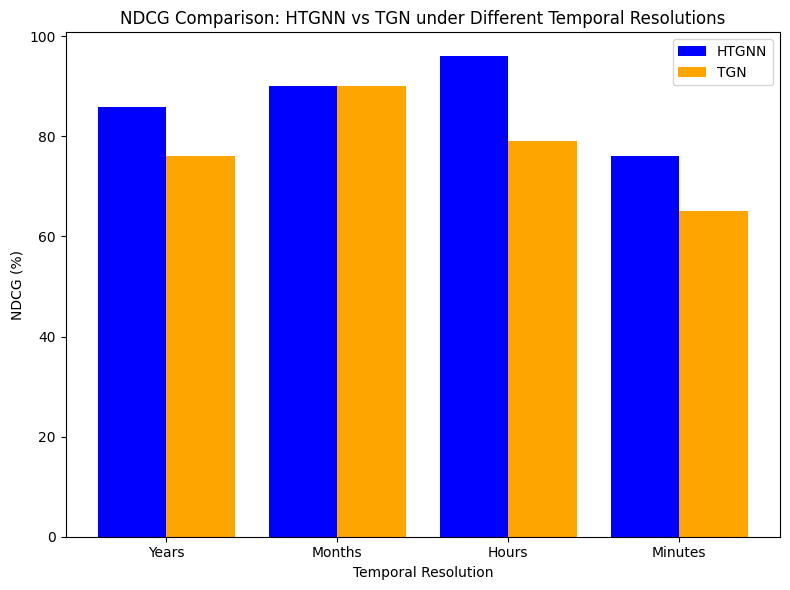

In [ ]:
import matplotlib.pyplot as plt

# Data for the graph
temporal_resolutions = ['Years', 'Months', 'Hours', 'Minutes']
htgnn_ndcg = [85.8, 90, 96, 76]
tgn_ndcg = [76, 90, 79, 65]

# Create a bar chart
x = range(len(temporal_resolutions))

plt.figure(figsize=(8, 6))
plt.bar(x, htgnn_ndcg, width=0.4, label='HTGNN', color='blue', align='center')
plt.bar([i + 0.4 for i in x], tgn_ndcg, width=0.4, label='TGN', color='orange', align='center')

# Add labels and title
plt.xlabel('Temporal Resolution')
plt.ylabel('NDCG (%)')
plt.title('NDCG Comparison: HTGNN vs TGN under Different Temporal Resolutions')
plt.xticks([i + 0.2 for i in x], temporal_resolutions)
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()